# Object detection with TensorFlow

This notebook contains a simple implementation of a Deep Learning model for **object detection**.

The model presented in this repository has been totally implemented using open source tools (i.e., Python and TensorFlow).


## Imports

In [1]:
# General imports
import numpy as np ; np.random.seed(1) # for reproducibility
import pandas as pd
import cv2 
import uuid
import os
import time
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import object_detection
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
import shutil
import requests
import tarfile
import json
from google.protobuf import text_format

# TensorFlow
import tensorflow as tf
from tensorflow import keras

### TensorFlow information

In [2]:
# Indicate the version of Tensorflow and whether it uses the CPU or the GPU
print("TensorFlow version:", tf.__version__)

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("The GPU will be used for calculations.")
    
else:
    print("The CPU will be used for calculations.")

TensorFlow version: 2.4.0
The CPU will be used for calculations.


## Functions

In [3]:
def countdown(number):
    
    """
    Print countdown.
    
    Parameters:
    number (int): Number used for the countdown in seconds.
    """
    
    for i in range(number,0,-1):
        print('{}...'.format(i))
        time.sleep(1)

In [4]:
def take_pictures(list_classes, number_pictures, path_data_raw, number, device):
    
    """
    Take pictures from the webcam every X seconds and save the data locally.
    
    Parameters:
    list_classes (list): List of possible classes to be pictured.
    number_pictures (int): Number specifing the number of pictures per class to be taken.
    path_data_raw (Path): Path to the folder where the images must be saved.
    number (int): Number used for the countdown in seconds.
    device (string): Either the 'built-in' camera, or the 'external' one (useful for laptops).
    """
    
    # Define time before start
    start_gap = 5

    # Print info 
    print('\nWe will take pictures for {} classes: {}'.format(len(list_classes), list_classes))
    print('Will start in about {} seconds...'.format(start_gap))
    time.sleep(start_gap)
    
    # Iterate over each class
    for label in list_classes:
        
        # Print info
        print("\n - Let's take {} pictures for {}: \n".format(number_pictures, label))
        time.sleep(number)
        
        # Select camera
        if device == 'built-in':
            camera = cv2.VideoCapture(0)
        elif device == 'external':
            camera = cv2.VideoCapture(1)
        
        # Take the number of pictures specified
        for pic in range(1, number_pictures + 1):
            
            # Print countdown until picture
            countdown(number)
            
            # Take picture
            print('Photo {}! ({}) \n'.format(pic, label))
            _, image = camera.read()
            
            # Save image
            img_path = os.path.join(path_data_raw, label, '{}_{}.jpg'.format(label, pic))
            print(img_path)
            cv2.imwrite(img_path, image)
        
        # Wait before next class
        time.sleep(3)
    
    # Close camera
    camera.release()
    del(camera)
    cv2.destroyAllWindows()

In [5]:
def restart_directory(path):
    
    """
    Restart a directory:
        If it already exists, remove it and creates a new one.
        If it doesn't exist yet, create it.
    
    Parameters:
    path_data_raw (Path): Path to the folder to be restarted.
    """

    if os.path.exists(path):
        shutil.rmtree(path)
        os.mkdir(path)
    else:
        os.mkdir(path)

## Set up directories

In [6]:
# Set paths
PATH_DATA = Path('data')
PATH_RAW_DATA = Path(os.path.join(PATH_DATA, 'raw'))
PATH_PROCESSED_DATA = Path(os.path.join(PATH_DATA, 'processed'))
PATH_RECORDS_DATA = Path(os.path.join(PATH_DATA, 'records'))
PATH_PRE_TRAINED = Path('pre_trained_model')

## Import data

In this section, we will generate the training, validation and test sets, which will be composed of actual images taken by ourselves.

In [7]:
# Define classes
classes = ['Mask', 'No-mask']

In [8]:
# Get paths to folders
PATH_MASK = Path(os.path.join(PATH_RAW_DATA, 'Mask')) 
PATH_NO_MASK = Path(os.path.join(PATH_RAW_DATA, 'No-mask')) 

In [9]:
# Specify if you want to refresh pictures
refresh_pictures = False
if refresh_pictures:
    
    # Remove previous stored pictures
    restart_directory(PATH_MASK) 
    restart_directory(PATH_NO_MASK)
    
    # Take 10 pictures for each class every 2 seconds and save them locally
    take_pictures(classes, 20, PATH_RAW_DATA, 2, 'external') # I use an external webcam

## Describe data

In [10]:
# Describe data size
for label in classes:
    
    # Get list of files in folder
    list_files = os.listdir(os.path.join(PATH_DATA, 'raw', label))

    # Avoid non-relevant elements in folders
    list_files = [pic for pic in list_files if pic.endswith('.jpg')]
    
    # Print number of pictures per folder
    num_files = len(list_files)
    print('Total {} images: {}'.format(label, num_files))

Total Mask images: 20
Total No-mask images: 20


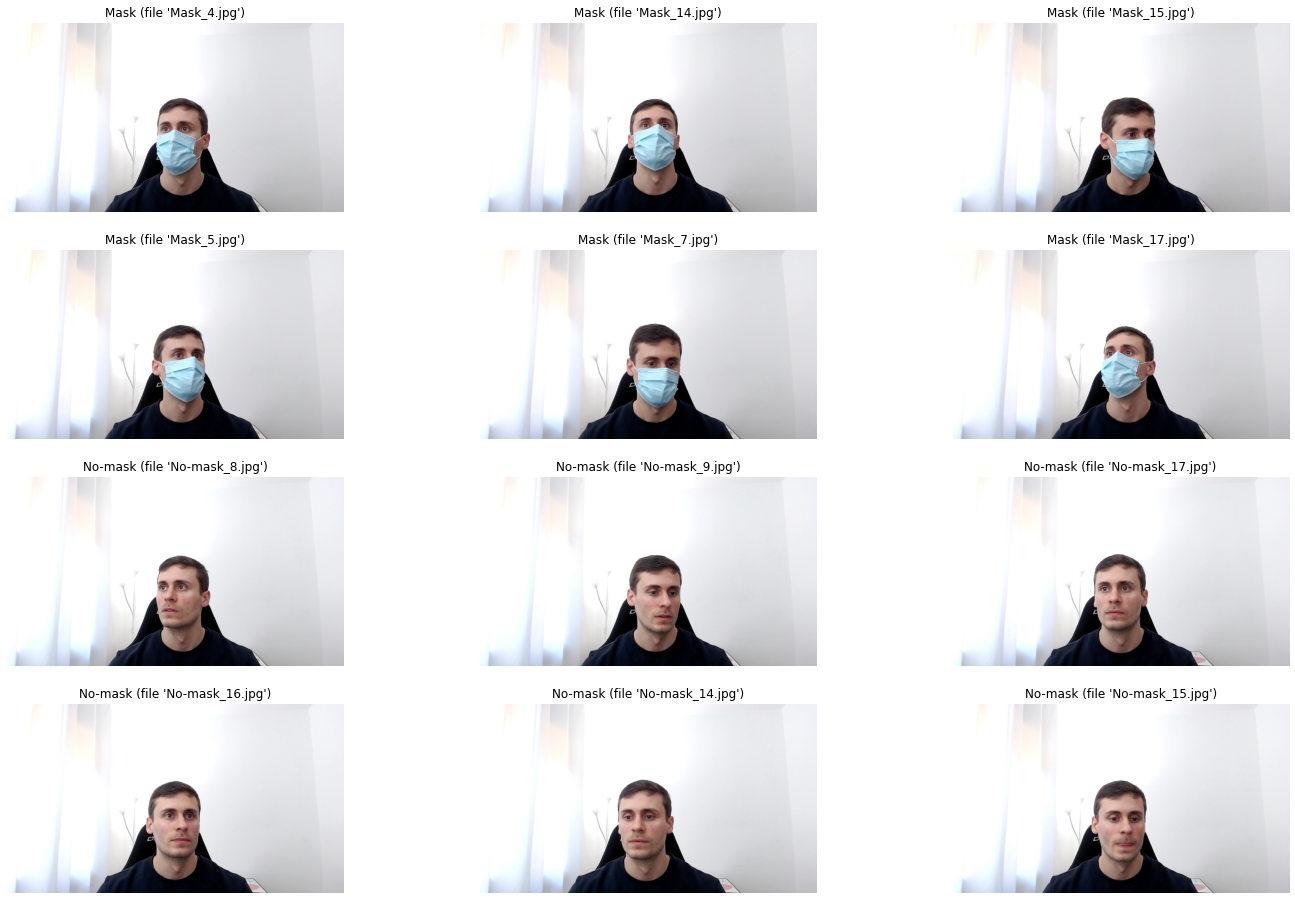

In [11]:
# Number of pictures in the grid
nrows = 4
ncols = 3

# Set up matplotlib fig
longitude_image = 8 # Inches per picture
fig = plt.gcf()
fig.set_size_inches(ncols * longitude_image, nrows * longitude_image / 2)

# List all files per folder
mask_files = os.listdir(PATH_MASK)
no_mask_files = os.listdir(PATH_NO_MASK)

# Remove non-relevant elements in folders
mask_files = [pic for pic in mask_files if pic.endswith('.jpg')]
no_mask_files = [pic for pic in no_mask_files if pic.endswith('.jpg')]

# Get paths to each file
list_mask_pix = [os.path.join(PATH_MASK, fname) for fname in mask_files]
list_no_mask_pix = [os.path.join(PATH_NO_MASK, fname) for fname in no_mask_files]

# Get each image
for i, img_path in enumerate(list_mask_pix[:(ncols*2)] + list_no_mask_pix[:(ncols*2)]):
    folder_name = img_path.split("/")[2]
    picture_name = img_path.split("/")[3]
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title("{} (file '{}')".format(folder_name, picture_name))

# Plot grid
plt.show()

## Label pictures

At this point, we have to label the images. For that purpose, I suggest using **[LabelImg](https://github.com/tzutalin/labelImg)**, a graphical image annotation tool. 

The process is the following:

**1. Clone the repo in your current directory**.

**2. Set up tool**.

**3. Label images**.

<br>

### Clone LabelImg repo

In [12]:
# Clone labelImg repository
if not os.path.exists('labelImg'):
    !git clone https://github.com/tzutalin/labelImg

### Set up the labelling tool

In [13]:
# Set up labelling tool
!cd labelImg && make qt5py3

pyrcc5 -o libs/resources.py resources.qrc


### Label images

In [14]:
# Label images
!cd labelImg && python labelImg.py

![](img/screenshot_labelling.gif)

## Create train and test set

In [15]:
# Set train/test paths
TRAIN_DATA = Path(os.path.join(PATH_PROCESSED_DATA, 'train')) 
TEST_DATA = Path(os.path.join(PATH_PROCESSED_DATA, 'test')) 

# Set Mask/No-mask paths
TRAIN_DATA_MASK = Path(os.path.join(TRAIN_DATA, 'Mask')) 
TRAIN_DATA_NO_MASK = Path(os.path.join(TRAIN_DATA, 'No-mask'))
TEST_DATA_MASK = Path(os.path.join(TEST_DATA, 'Mask')) 
TEST_DATA_NO_MASK = Path(os.path.join(TEST_DATA, 'No-mask')) 

In [16]:
# Make a copy of the pictures files
list_mask_pix_jpg = list_mask_pix
list_no_mask_pix_jpg = list_no_mask_pix

In [17]:
# Get list of .jpg as well as .xml (i.e., boundary boxes)
list_mask_pix_xml = [pic.replace('.jpg', '.xml') for pic in list_mask_pix_jpg]
list_mask_files = sorted(list_mask_pix_jpg + list_mask_pix_xml)
list_no_mask_pix_xml = [pic.replace('.jpg', '.xml') for pic in list_no_mask_pix_jpg]
list_no_mask_files = sorted(list_no_mask_pix_jpg + list_no_mask_pix_xml)

In [18]:
# Use 20% of the instances as test set
split = round(len(list_mask_pix)*0.8)

# Get training set
train_mask = list_mask_files[:split]
train_no_mask = list_no_mask_files[:split]

# Get test set
test_mask = list_mask_files[split:]
test_no_mask = list_no_mask_files[split:]

# Restart directories
restart_directory(TRAIN_DATA_MASK) 
restart_directory(TRAIN_DATA_NO_MASK)
restart_directory(TEST_DATA_MASK) 
restart_directory(TEST_DATA_NO_MASK)

# Copy pictures to train/test folders
for pic in train_mask:
    shutil.copy2(pic, TRAIN_DATA_MASK)
for pic in train_no_mask:
    shutil.copy2(pic, TRAIN_DATA_NO_MASK)
for pic in test_mask:
    shutil.copy2(pic, TEST_DATA_MASK)
for pic in test_no_mask:
    shutil.copy2(pic, TEST_DATA_NO_MASK)

## Create label map

*TensorFlow* requires a label map to transform each label into an integer. 

In [19]:
# Create label dictionary
labels = [
    {'name':'Mask', 'id':1}, 
    {'name':'No-mask', 'id':2}
]

# Save as a new file
with open('label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

## Install Object Detection from TensorFlow 

In [20]:
# Clone TensorFlow models repository
if not os.path.exists('models'):
    !git clone https://github.com/tensorflow/models.git

In [21]:
# Compile protos
!cd models/research && protoc object_detection/protos/*.proto --python_out=.

In [22]:
# Instal actual API
!cp models/research/object_detection/packages/tf2/setup.py models/research/ 
!python -m pip install models/research/.

Processing ./models/research


  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1648085 sha256=d19102921e77c09be50f7920a51511342d7f3b9f765f6752468351a43bf89fee
  Stored in directory: /private/var/folders/h9/s9pkvt5s0lx9jh43_mjmz4l00000gp/T/pip-ephem-wheel-cache-k3zbzqwu/wheels/23/9a/69/4f65a2ce0346f9351bd078072a77967ddbd2cc6739161db2de
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [23]:
# Test that the Object Detection API is correctly installed
!cd models/research && python object_detection/builders/model_builder_tf2_test.py

Running tests under Python 3.8.5: /Users/guillermolahuerta/miniconda3/envs/object_detection/bin/python
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model
2021-05-07 16:39:14.431842: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-07 16:39:14.432020: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model): 0.67s
I0507 16:39:14.710950 4639620608 test_util.py:2075] time(__main__.ModelBuilderTF2Test.test_create_center_net_model): 0.67s
[       OK ] ModelBuilderTF2Test.test_create_center_net_model
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model_from_keypoints
INFO:ten

I0507 16:39:16.819036 4639620608 ssd_efficientnet_bifpn_feature_extractor.py:142] EfficientDet EfficientNet backbone version: efficientnet-b1
I0507 16:39:16.819148 4639620608 ssd_efficientnet_bifpn_feature_extractor.py:144] EfficientDet BiFPN num filters: 88
I0507 16:39:16.819200 4639620608 ssd_efficientnet_bifpn_feature_extractor.py:145] EfficientDet BiFPN num iterations: 4
I0507 16:39:16.822705 4639620608 efficientnet_model.py:147] round_filter input=32 output=32
I0507 16:39:16.835471 4639620608 efficientnet_model.py:147] round_filter input=32 output=32
I0507 16:39:16.835583 4639620608 efficientnet_model.py:147] round_filter input=16 output=16
I0507 16:39:16.924666 4639620608 efficientnet_model.py:147] round_filter input=16 output=16
I0507 16:39:16.924762 4639620608 efficientnet_model.py:147] round_filter input=24 output=24
I0507 16:39:17.076609 4639620608 efficientnet_model.py:147] round_filter input=24 output=24
I0507 16:39:17.076707 4639620608 efficientnet_model.py:147] round_filt

I0507 16:39:19.720744 4639620608 efficientnet_model.py:147] round_filter input=24 output=32
I0507 16:39:19.720839 4639620608 efficientnet_model.py:147] round_filter input=40 output=48
I0507 16:39:19.871294 4639620608 efficientnet_model.py:147] round_filter input=40 output=48
I0507 16:39:19.871395 4639620608 efficientnet_model.py:147] round_filter input=80 output=96
I0507 16:39:20.125185 4639620608 efficientnet_model.py:147] round_filter input=80 output=96
I0507 16:39:20.125283 4639620608 efficientnet_model.py:147] round_filter input=112 output=136
I0507 16:39:20.534910 4639620608 efficientnet_model.py:147] round_filter input=112 output=136
I0507 16:39:20.535006 4639620608 efficientnet_model.py:147] round_filter input=192 output=232
I0507 16:39:20.852874 4639620608 efficientnet_model.py:147] round_filter input=192 output=232
I0507 16:39:20.852971 4639620608 efficientnet_model.py:147] round_filter input=320 output=384
I0507 16:39:20.972629 4639620608 efficientnet_model.py:147] round_filt

I0507 16:39:25.292791 4639620608 efficientnet_model.py:147] round_filter input=1280 output=2048
I0507 16:39:25.325008 4639620608 efficientnet_model.py:458] Building model efficientnet with params ModelConfig(width_coefficient=1.6, depth_coefficient=2.2, resolution=456, dropout_rate=0.4, blocks=(BlockConfig(input_filters=32, output_filters=16, kernel_size=3, num_repeat=1, expand_ratio=1, strides=(1, 1), se_ratio=0.25, id_skip=True, fused_conv=False, conv_type='depthwise'), BlockConfig(input_filters=16, output_filters=24, kernel_size=3, num_repeat=2, expand_ratio=6, strides=(2, 2), se_ratio=0.25, id_skip=True, fused_conv=False, conv_type='depthwise'), BlockConfig(input_filters=24, output_filters=40, kernel_size=5, num_repeat=2, expand_ratio=6, strides=(2, 2), se_ratio=0.25, id_skip=True, fused_conv=False, conv_type='depthwise'), BlockConfig(input_filters=40, output_filters=80, kernel_size=3, num_repeat=3, expand_ratio=6, strides=(2, 2), se_ratio=0.25, id_skip=True, fused_conv=False, conv

INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_ssd_models_from_config): 16.33s
I0507 16:39:31.952502 4639620608 test_util.py:2075] time(__main__.ModelBuilderTF2Test.test_create_ssd_models_from_config): 16.33s
[       OK ] ModelBuilderTF2Test.test_create_ssd_models_from_config
[ RUN      ] ModelBuilderTF2Test.test_invalid_faster_rcnn_batchnorm_update
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_invalid_faster_rcnn_batchnorm_update): 0.0s
I0507 16:39:31.960729 4639620608 test_util.py:2075] time(__main__.ModelBuilderTF2Test.test_invalid_faster_rcnn_batchnorm_update): 0.0s
[       OK ] ModelBuilderTF2Test.test_invalid_faster_rcnn_batchnorm_update
[ RUN      ] ModelBuilderTF2Test.test_invalid_first_stage_nms_iou_threshold
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_invalid_first_stage_nms_iou_threshold): 0.0s
I0507 16:39:31.962516 4639620608 test_util.py:2075] time(__main__.ModelBuilderTF2Test.test_invalid_first_stage_nms_iou_threshold): 0.0s
[       OK ]

## Generate TF records

Tensorflow needs the bounding box locations for every image in a specific format, i.e., as a *TFRecord*.

In [24]:
# Create train and test records
!python generate_tfrecord.py -x data/processed/train -l label_map.pbtxt -o data/records/train.record
!python generate_tfrecord.py -x data/processed/test -l label_map.pbtxt -o data/records/test.record

Successfully created the TFRecord file: data/records/train.record
Successfully created the TFRecord file: data/records/test.record


## Download TensorFlow pre-trained models

To begin with, we need to download the latest pre-trained network for the [model](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) we wish to use. 

Let's use [SSD ResNet50 V1 FPN 640x640](http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz).

In [25]:
# Download pre-trained model
model_name = 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8'
model_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
model_path = model_name + '.tar.gz'
response = requests.get(model_url + model_path, stream=True)
if response.status_code == 200:
    with open(target_path, 'wb') as f:
        f.write(response.raw.read())

NameError: name 'target_path' is not defined

In [99]:
# Decompress file
tar = tarfile.open(model_path)
tar.extractall()
tar.close()

# Remove compressed file
os.remove(model_path)

## Configure training

In [118]:
# Define hyper-parameters
batch_size = 8
epochs = 10

In [123]:
# Get config path
PATH_COFIG = os.path.join(model_name, 'pipeline.config')
PATH_COFIG_MOD = os.path.join(PATH_PRE_TRAINED, 'pipeline.config')

# Get config file
config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(PATH_COFIG, "r") as f:
    config_old = f.read()
    text_format.Merge(config_old, config)
    
# Prepare a modified version
config_new = open(PATH_COFIG_MOD, "wt")

# Update values
config.model.ssd.num_classes = len(classes)
config.train_config.batch_size = batch_size
config.train_config.fine_tune_checkpoint = os.path.join(model_name, 'checkpoint', 'ckpt-0')
config.train_config.fine_tune_checkpoint_type = 'detection'
config.train_config.num_steps = epochs
config.train_config.use_bfloat16 = False
config.train_input_reader.label_map_path = 'label_map.pbtxt'
config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(PATH_RECORDS_DATA,'train.record')]
config.eval_input_reader[0].label_map_path = 'label_map.pbtxt'
config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(PATH_RECORDS_DATA,'test.record')]

# Save new file
config_new = text_format.MessageToString(config)
with tf.io.gfile.GFile(PATH_COFIG_MOD, "wb") as f:
    f.write(config_new)
    
# Copy model executable
shutil.copy2('models/research/object_detection/model_main_tf2.py', '.')

'./model_main_tf2.py'

## Train model

In [121]:
# Train model
!python model_main_tf2.py --model_dir=pre_trained_model --pipeline_config_path=pre_trained_model/pipeline.config

2021-05-04 09:06:59.352128: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-04 09:06:59.352365: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0504 09:06:59.353181 4747456000 cross_device_ops.py:1321] There are non-GPU devices in `tf.distribute.Strategy`, not using nccl allreduce.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
I0504 09:06:59.353318 4747456000 mirrored_strategy.py:350] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I0504 09:06:59.356293 4747456000 config_util.py:552] Maybe overwriting train_steps: